## Обучить модель семантической сегментации (человек-vs-фон) на подмножестве датасета MS COCO
Библиотеки: [Python, Tensorflow]

In [1]:
# For local Jupyter Notebook 
# from IPython.core.display import display, HTML, Image
# display(HTML('<style>.container { width:72.5% !important; }</style>'))

In [2]:
import time

import os
import skimage.io as io

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Загрузка датасета COCO и COCO API

In [4]:
# pip install pycocotools
# pip install cython

In [5]:
# if 1:
    # !mkdir -p data

    # !cd data && wget http://images.cocodataset.org/zips/train2017.zip 
    # !cd data && wget http://images.cocodataset.org/zips/val2017.zip 
    # !cd data && wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip 

    # !cd data && unzip -q train2017.zip
    # !cd data && unzip -q val2017.zip
    # !cd data && unzip -q annotations_trainval2017.zip

    # !cd data && git clone https://github.com/cocodataset/cocoapi
    # !cd data/cocoapi/PythonAPI
    # !cd data/cocoapi/PythonAPI && make

## Подготовка COCO API

In [6]:
COCO_ROOT = './data/'
import sys
sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))
from pycocotools.coco import COCO

## Универсальный класс Dataset для сегментации

In [7]:
class Dataset():

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

## Класс для сегментационного датасета COCO
Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.

In [8]:
class COCO_Dataset(Dataset):

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['captions'])
        self.cat_ids = self.cat_ids
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [9]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=12.55s)
creating index...
index created!
loading annotations into memory...
Done (t=0.45s)
creating index...
index created!


## Создание пайплайна данных

In [10]:
INP_SIZE = 128
NUM_EPOCHS = 1
BATCH_SIZE = 32

train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, inp_size=INP_SIZE)
test_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=INP_SIZE)

In [11]:
train_ds

<BatchDataset shapes: ((32, 128, 128, None), (32, 128, 128, None)), types: (tf.float32, tf.float32)>

In [12]:
test_ds

<BatchDataset shapes: ((32, None, None, None), (32, None, None, None)), types: (tf.float32, tf.float32)>

In [13]:
len(train_ds), len(test_ds)

(3696, 156)

In [14]:
# train_ds = train_ds.take(24)

## Визуализация датасета

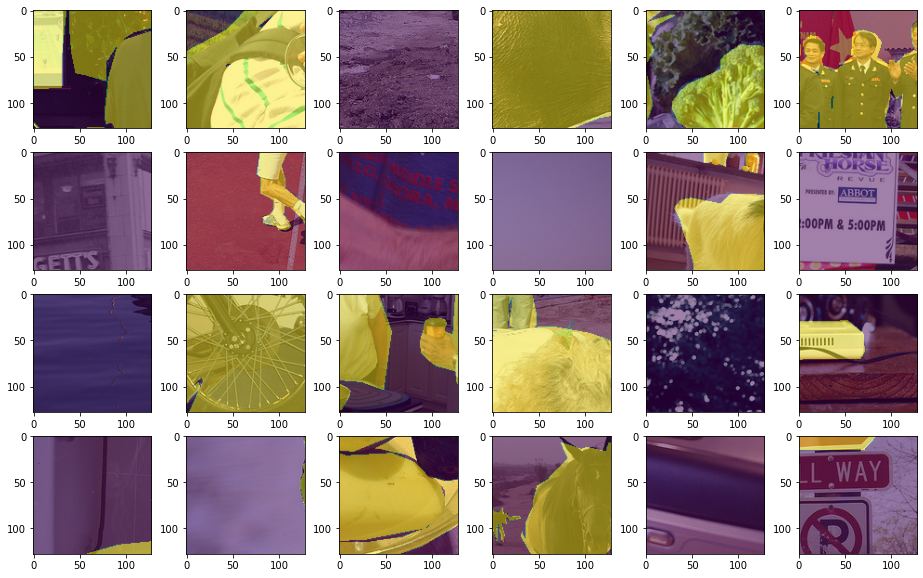

In [15]:
image, mask = next(iter(train_ds.take(24)))

fig = plt.figure(figsize=(16, 10))
for i in range(24):
    ax = fig.add_subplot(4, 6, i+1)
    ax.imshow(image[i])
    ax.imshow(mask[i, ..., 0], alpha=0.5)
plt.show()

## Модель U-Net

In [16]:
def build_model():
    x = tf.keras.layers.Input((128, 128, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

## Контрольные точки

## Обучение модели

Epoch 1/5
3696/3696 [==============================] - 2706s 729ms/step - loss: 0.5811 - val_loss: 0.6164
Epoch 2/5
3696/3696 [==============================] - 2515s 681ms/step - loss: 0.5444 - val_loss: 0.6188
Epoch 3/5
3696/3696 [==============================] - 2620s 709ms/step - loss: 0.5234 - val_loss: 0.5600
Epoch 4/5
3696/3696 [==============================] - 2292s 620ms/step - loss: 0.5070 - val_loss: 0.5755
Epoch 5/5
3696/3696 [==============================] - 2405s 651ms/step - loss: 0.5060 - val_loss: 0.6085


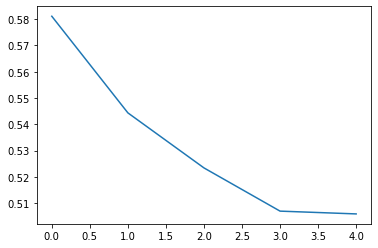

In [17]:
NUM_EPOCHS = 5
BATCH_SIZE = 1

loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer='adam', loss=loss)

hist = model.fit(train_ds, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=test_ds)

plt.plot(hist.history['loss'])

## Запуск предсказания для случайного изображения

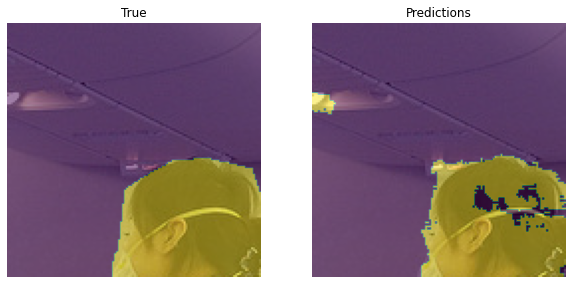

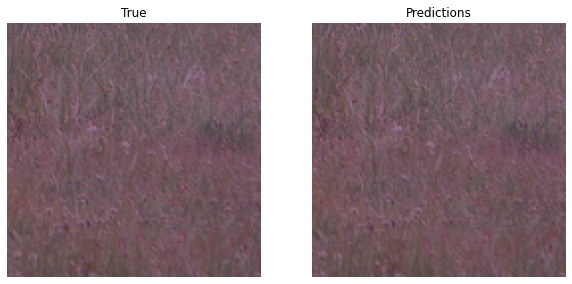

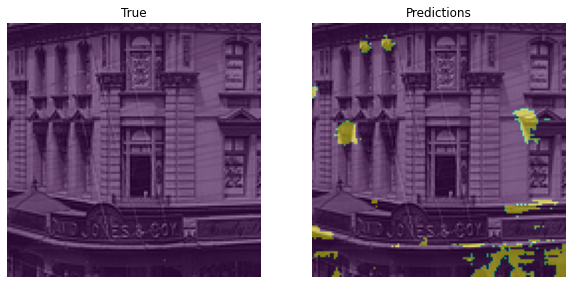

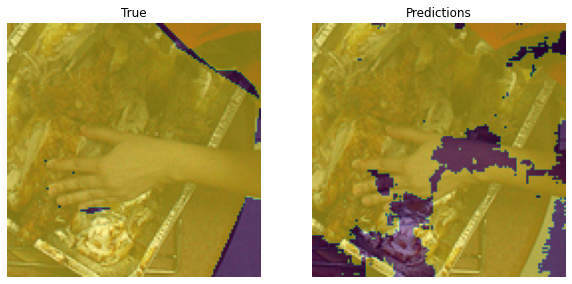

In [27]:
import random

idx = random.randint(0, 24)

X_train, y_train = next(iter(train_ds.take(idx)))

PERCEPTION = 0.5

pred_prob = model(X_train[:4]).numpy()
pred_mask = (pred_prob[..., 0] > PERCEPTION).astype(np.float32)

for i in range(4):
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('True')
    plt.imshow(X_train[i])
    plt.imshow(y_train[i, ..., 0], alpha=0.5)
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Predictions')
    plt.imshow(X_train[i])
    plt.imshow(pred_mask[i], alpha=0.5)
    plt.axis('off')

## + ASSP
[hw_les_4-ASPP](https://github.com/djo1006/Deep-Learning-in-Computer-Vision/blob/main/hw_les_4-ASPP.ipynb)